This Jupyter Notebook shows an example of how COM-COM distributions are determined and fitted for Figure 2

Trajectories from simulations fo NTD-RBD constructs and rU25 are run and the begining of the simulations (0.02%) are removed for equilibration using MDTraj

The tool lammpstools_build_comtraj is used to generate center of mass trajectories of the residue and nucleotide coarse grained simulations.

Each construct has several sets of simulations where different starting RBD conformations are used and these are run with several different replicates.

All the COM trajectories for each construct and its different starting RBD constructs are concatenated otgether using the tool cattraj, which will generate one long continuos trajectory

The RBD simulations were analyzed the same way as above in the paper, but an analogous way of determining bound states can be done by instead summing COM distance information for each conformation in the Jupyter notebook

This Notebook shows the two (analagous) ways that COM-COM trajectories are analyzed in this paper with trajectories summed before or within the notebook

These are then used to fit distributions to determine cutoffs for constructs 

In [1]:
import seaborn as sns
import pandas as pd
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pylab as pylab

from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
%matplotlib inline

import scipy as scipy

from scipy import optimize

from soursop.sstrajectory import SSTrajectory
import mdtraj as md

import csv

# define this so we can read in nucleotides
NA_EXTENSION = ['D5P', 'DPC',  'DPU',  'DPT',  'DPA',  'DPG',  'R5P',  'RPC' , 'RPU',  'RPT',  'RPA',  'RPG']

# molecular weight of N protein (g/mol)
MW_N = 18850
M2nM=1e9

# importing mean()
from statistics import mean
  
def Average(lst):
    return mean(lst)

import numpy as np

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['legend.fontsize'] = 6

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'


Bad key "text.kerning_factor" on line 4 in
/home/alstonj/miniconda3/envs/labconda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def correctRDF(r, rdf, L):
    """
    Implementation of corrected radial distribution
    function as taken directly from Ganguly and van der Vegt [1],
    using the impmentation by Tesei et al.[2].
    
    This requires that the distance bins (r) be in the same units
    as the box length (L). Typically both will be in nanometers.
    
    Recall the radial distrubution function (g(r)) rorts on the
    density of molecules at some distance from the center as a ratio
    of the actual density/expected density in bulk - i.e. this is a 
    unitless value (ratio of 2 densities).
    
    As an side, this also means the Meyer integral of the radial 
    distribution function returns the B22 in units of distance used 
    cubed (i.e. volume).        
        
    Parameters
    -------------
    r : np.ndarray
        Array of bin positions for the radial distribution function
        (rdf).
        
    rdf : np.ndarray
        Counts associated with the corresponding bins for the RDF. 
        
    L : float
        Box dimensions (in nanometers)
        
    Returns
    ------------
    np.array
        Corrected counts associated with the corresponding bins for 
        the RDF
    
    Reference
    --------------
    [1] Ganguly, P., & van der Vegt, N. F. A. (2013). Convergence of Sampling 
        Kirkwood-Buff Integrals of Aqueous Solutions with Molecular Dynamics 
        Simulations. Journal of Chemical Theory and Computation, 9(3), 1347–1355.
        
    [2] Tesei, G., Schulze, T. K., Crehuet, R., & Lindorff-Larsen, K. (2021). 
        Accurate model of liquid–liquid phase behavior of intrinsically disordered 
        proteins from optimization of single-chain properties. Proceedings of the 
        National Academy of Sciences of the United States of America, 118(44). 
        https://doi.org/10.1073/pnas.2111696118
    """
    
    
    # get bin width
    dr = r[1]-r[0]
    
    # volume of box in nm cubed
    V = L**3
    
    Nouter = 1 - 4/3*np.pi*r**3 / V
    
    DeltaN = 1/V*4*np.pi*dr*np.cumsum( (rdf - 1 ) * r**2)
    
    return rdf * Nouter / ( Nouter  - DeltaN)


# ......................................................
#
def naive_Kd(p_bound, L):
    """
    Calculate the binding affinity using the so-called niave 
    assumption from Jost et al. [1]
        
    Parameters
    --------------
    p_bound : float
        Fraction of the simulation in which the two molecules 
        are bound. How one defines 'bound' is often the hard 
        question. This is unitless (i.e. is a fraction)
        
    L : float
        Box dimensions (in nanometers)
        
    Returns
    -------------
    float
    
        Returns the kD in molar units (mol/L)
        
    Reference
    --------------
    [1] - Jost Lopez, A., Quoika, P. K., Linke, M., Hummer, G., 
    & Köfinger, J. (2020). Quantifying Protein–Protein Interactions 
    in Molecular Simulations. The Journal of Physical Chemistry. B, 
    124(23), 4673–4685.

    """
    
    # Avogadro's number - recall that 1/NA gives us units of mol
    # because NA/NA = 1 mol 
    N_A = 6.02214076*1e23
    
    # Volume of simulation box in L (convert to cubic meters and)
    # then to liters
    V = 1e3*((L*1e-09)**3)
    
    # kd (in mol/L) determined from p_bound
    kd = ((1-p_bound)**2) / (N_A*V*p_bound)
    print(p_bound)
    
    return kd


# ......................................................
#
def kd_from_b22(b22, p_bound, L, MW_A, MW_B):
    """
    Calculate the dissociation constant using B22 as a correction
    factor to account for intrinsic non-specific binding, as defined
    in Jost et al. [1].
    
    Parameters
    --------------
    b22 : float
        Second virial coefficient, in units of l mol / g^2 [that's
        liters mols per gram squared].
        
    p_bound : float
        Fraction of the simulation that the molecules are bound, this
        is unitless
        
    L : float
        Box dimensions (in nm)
        
    MW_A : float
        Molecular weight of reference molecule (in g/mol)

    MW_B : float
        Molecular weight of query molecule (in g/mol)

    Returns
    ------------
    float
        Returns the B22-corrected Kd in M
        
    Reference
    -----------
    [1] - Jost Lopez, A., Quoika, P. K., Linke, M., Hummer, G., 
    & Köfinger, J. (2020). Quantifying Protein–Protein Interactions 
    in Molecular Simulations. The Journal of Physical Chemistry. B, 
    124(23), 4673–4685.
    """
    
    # Avogadro's number in units 1/mol
    N_A = 6.02214076*1e23
    
    # Volume of simulation box in L
    V = ((L*1e-09)**3)*1000
    
    # conversion factor for b22 (from µl mol / g2 to L) 
    # recall MW_A *MW_B = g^2/mol^2 * 1/N_A = g^2/mol^1
    
    convert_units = (MW_A * MW_B)*1e-6/N_A
    
    # return Jost equation in the right unit - 1/Na * 1/vol
    # 1/Na = mol units and 1/vol - l^{-1} units, so 
    # final units are mol/l (or M)
    return 1/(N_A*p_bound*(V-2*b22*convert_units))
    

# ......................................................
#
def calcB22(r, rdf, MW_A, MW_B):
    """
    Returns second virial coefficient in 
    microliters * mol / grams squared
    
    Parameters
    ------------------
    r : np.ndarray
        Array of bin positions for the radial distribution function
        (rdf).
        
    rdf : np.ndarray
        Counts associated with the corresponding bins for the RDF.

    MW_A : float
        Molecular weight of molecule 1
        
    MW_B : float
        Molecular weight of molecule 2
        

    Returns
    -----------
    float
        Returns a Kd in µl mol / g2
    """
    
    # meyer F-integral - NOTE the negative sign here is needed
    # the inner integral is rdf - 1 instead of 1 - rdf
    B22 = -2*np.pi*np.trapz((rdf-1)*r*r,r)
    
    # note - this here is the original conversion equation implemented by
    # tesei et al
    #return B22 * 6.022e23 / 1e21 / MW**2 * 1e3 # µl mol / g2
    
    #  Below is the same numerical calculation just written
    # differently to make it a bit clearer what the conversion factors
    # are doing
    return B22 * 6.022e23 * (1/1e27) * 1e3 * 1e6 * (1/ (MW_A*MW_B))  # µl mol / g2
    

# ......................................................
#
def build_traces(COM_distances, bound_length, cutoff):
    """
    Function that assesses bound and unbound states based on contigous stretches of
    the simulation where the centers of mass are conistently below some threshold.
    
    In particular, $bound_length defines the number of consecutive frames which must 
    be below some threshold for a simulation to be considered bound. $cutoff defines what
    this distance threshold is. For example, if bound_length=20 (default) we only consider
    regions of the inter-molecular COM distance. 
    
    Parameters
    -------------
    COM_distances : np.ndarray
        Array of inter-molecular center of mass (COM) distances. Expect one value
        per frame.
        
    bound_length : int
        Number of consecutive frames required to designate an interaction as 'bound'
        
    cutoff : float
        Distance (in Angstroms) used to define if two molecules are bound or not. Note
        this is the COM distance, not the minimum contact distance (!).
        
        
    Returns
    -----------
    tuple
        Returns a tuple with three elements
        
        # fraction bound
        [0] - float      - the fraction bound of this simulation
        
        # bound_trace
        [1] - np.ndarray - shape=(2,n), where the two columns are the
                           index of a bound frame and the distance in 
                           that frame
                           
        # unbound_trace
        [2] - np.ndarray - shape=(2,n), where the two columns are the
                           index of a bound frame and the distance in 
                           that frame
    
    """

    # initialize some variables
    bound_trace = []
    unbound_trace = []
    inside = False

    all_bound_idx = set([])
    all_unbound_idx = set([])

    idx = bound_length-1
    
    # cycle over the bound_length-thed index to the end of
    # the COM array
    for idx in range(bound_length, len(COM_distance)):

        # get the distance at the idx position
        i = COM_distance[idx]

        # define the preceding bound_length-sized set of
        # frames (i.e. the 'history' is the set frames
        # that come $bound_length before the current 
        # index
        history = COM_distance[idx-bound_length:idx]

        # if we're already 'inside' a bound part of the
        # trajectory
        if inside:  
            
            # if under the cutoff then carry on, we've found
            # additional frames in a contigous set of frames 
            # that are bound
            if i < cutoff:            
                bound_trace.append([idx,i])
                all_bound_idx.add(idx)
                
            # if we're above the cutoff then this means an unbinding
            # event happens
            else:
                inside = False
                
        # if we're not currently inside a bound set of frames
        else:
            
            # if this frame is bound
            if i < cutoff:
                
                # if were the last set of frames all under the reshold
                if np.max(history) < cutoff:
                    
                    # if yes we're insidew
                    inside = True

                    for tmp_idx, tmp_i in enumerate(history):
                        local_idx = idx-(bound_length - tmp_idx)
                        bound_trace.append([local_idx, tmp_i])
                        all_bound_idx.add(local_idx)
                        
                    bound_trace.append([idx,i])
                    all_bound_idx.add(idx)


    # now, having classufued every frame, we can go through all the frames and 
    # if they're not in one of the all_bound_idx set they must be all unbound
    for idx in range(bound_length, len(COM_distance)):
        i = COM_distance[idx]
        if idx not in all_bound_idx:
            unbound_trace.append([idx,i])
            all_unbound_idx.add(idx)
        
    bound_trace = np.array(bound_trace).transpose()
    unbound_trace = np.array(unbound_trace).transpose()
    
    # calculate the fraction bound
    fraction_bound = len(all_bound_idx)/(len(all_unbound_idx)+len(all_bound_idx))
 
    return (fraction_bound, bound_trace, unbound_trace)



# ......................................................
#
def build_rdfs(cmtraj, L, bin_width=0.2):
    """
    Function that calculates the radial distribution function (g(r)) for our 
    center of mass trajectories. Specifically, this function expects `cmtraj`
    to be passed as an mdtraj.traj object where there are an arbitrarily large
    number of frames but there must ONLY be 2 chains where each chain has a 
    single residue - i.e. a center-of-mass trajectory
    
    Note that by default this implementation calculates the RDF between r=0 and
    r=L/2. This is important because if you make the upper limit of this integral
    big it causes some isues
    
    Parameters
    ---------------
    mdtraj.traj
        MDTraj trajectory object for a center-of-mass (COM) trajectory, i.e. a 
        trajectory with only 
        
    L : float
        Box size (in nanometers)
        
    
    bin_width : float
        Width of RDF bins in nanometers (recommend 0.2)
        
    Returns
    ----------
    
    """

    # half box size - for PBC corrected sims this is always correct
    max_integral = L/2
    
    rdf = md.compute_rdf(cmtraj, [[0,1]], r_range=(0,max_integral), bin_width = bin_width, periodic=True)
    
    rdf_c = correctRDF(rdf[0],rdf[1], L)
    
    return (rdf[0], rdf_c, rdf[1])

GS10
2181108
1: 51.5
0.17128260334335427
['GS10_Ka', 4.055225510212551e-06]
GS25
2129920
1: 52.5
0.1696560660871443
['GS25_Ka', 4.0009951465292764e-06]
SCO2
2180919
1: 46.5
0.6956147743560728
['SCO2_Ka', 0.0001220776967245444]
RBD
2200079
1: 47.5
0.2739269817129294
['RBD_Ka', 8.448680412785828e-06]


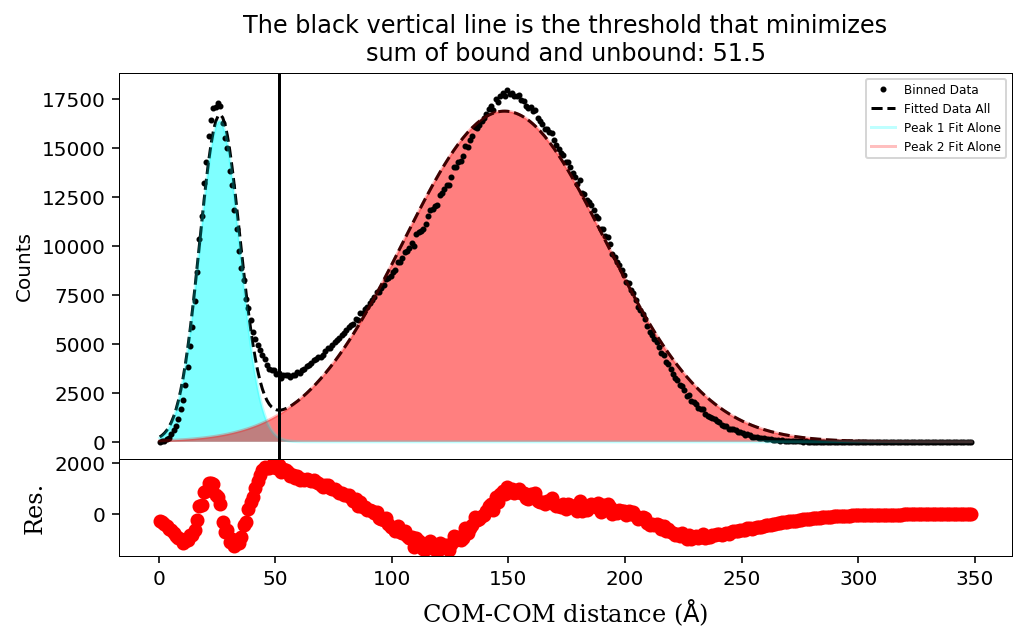

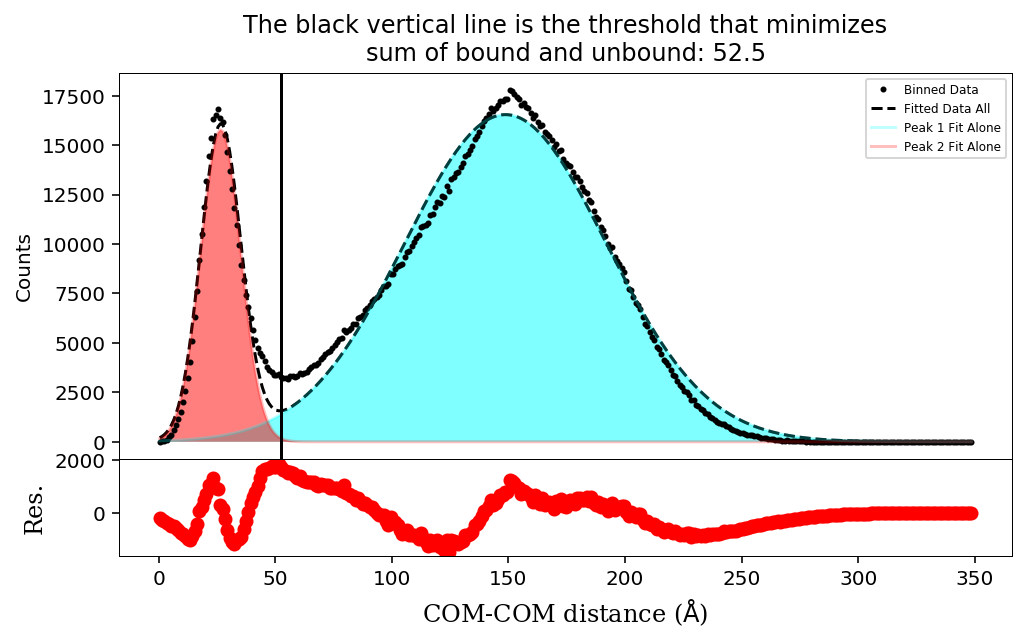

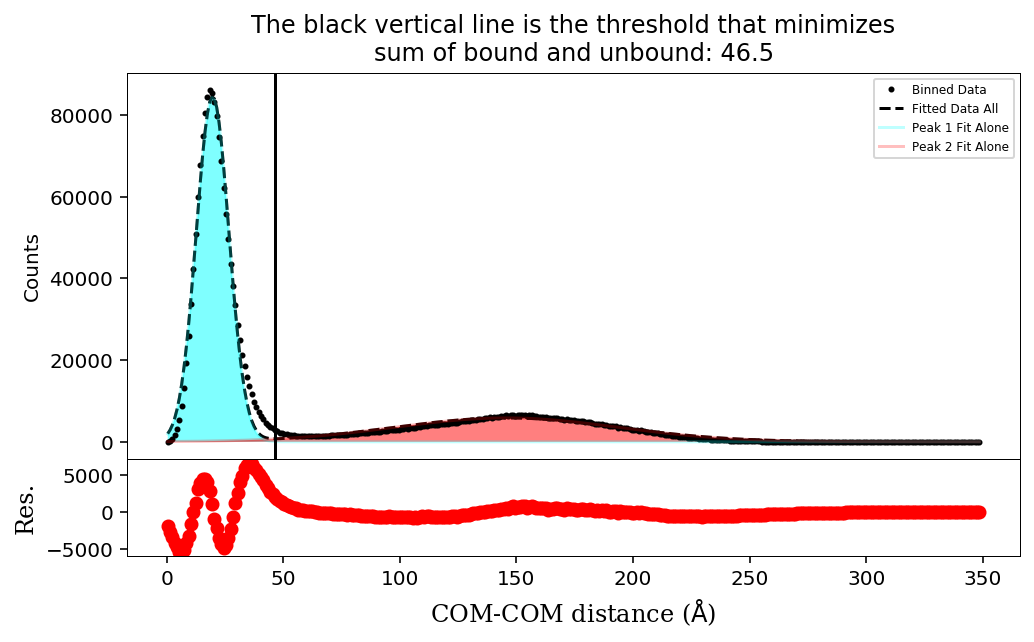

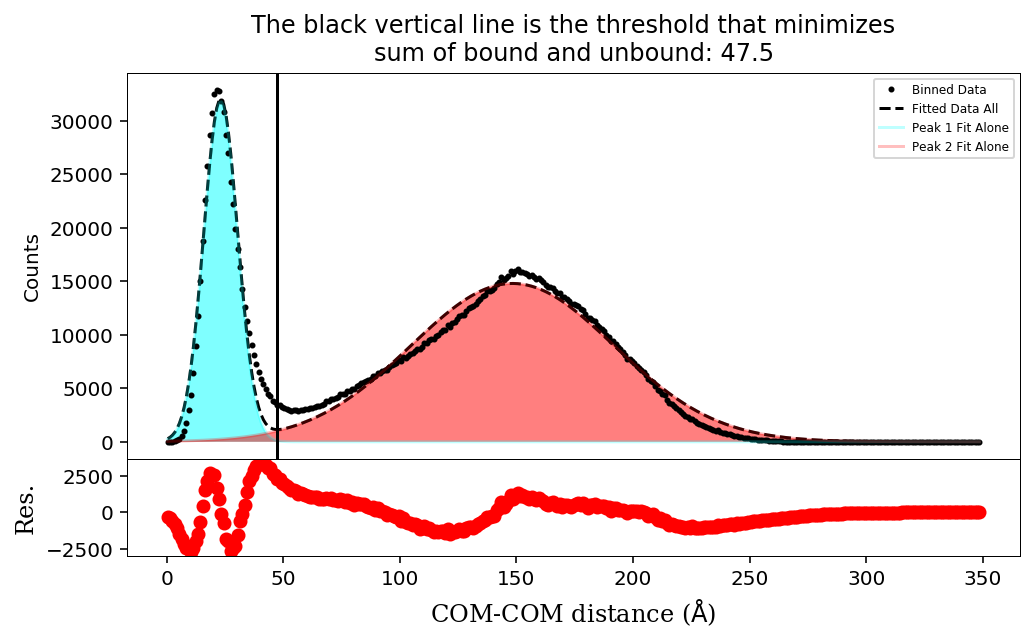

In [3]:
## This is for calculating replicates of a single type of simulation. IE 5 replicates of 1. protein and 1. RNA
## This is the main analysis cell for this entire workbook!
##

# Defines the folder where data is held
prefix = './Analysis/COMs'

# this is a single conversion factor that converts simulation Kd and Ka to experimental values
sim2exp_factor=1

# defines the number of replicates run, here we have concatenated all reps so there are no individualreplicates
Replicates = ['FULL']


# Define the Folder that your simulations are under. I make my folder names the name of the protein 
# system I am simulating.

Sequences = ['GS10', 'GS25', 'SCO2', 'RBD']

# box size (in nm)
L = 30

# rdf bin width
bin_width = 0.2

# this defines the number of contigous frames below the bound cutoff we need to say a
# chain is in the bound state. I played around a bit and 5 seemed quite reasonable but
# I have't explored this all that systematically... 
bound_length = 5

# Here we want to make it easy to plot individual simulations and there replicates fast so we store each 
# simulation type as its own list of values corresponding to the desired calculation

all_Kd_naive = []
all_Ka_naive = []

all_Kd_B22 = []
all_Ka_B22 = []
all_B22s = []

all_Kd_naive_std = []
all_Ka_naive_std = []


all_Kd_B22_std = []
all_B22s_std = []
all_Ka_B22_std = []

all_fraction_bound = []
all_fraction_bound_std = []


len2COM_distance = {}
len2COM_rdfs = {}
len2COM_bound_trace = {}
len2COM_unbound_trace = {}


# main loop - note this analysis for EVERYTHING actually only takes ~5-10 seconds (!!)
for seq in Sequences:
    
    #Values to save 
    Kd_naive_ = []
    Kd_B22_ = []
    B22s_ = []
    fraction_bound_ = []
    Ka_naive_ = []
    Ka_B22_ = []
    all_Ka_naive = []
    print(seq)
    all_fraction_bound = []
    All_distance = []
    flat_list = []
    
    for rep in Replicates:
    
        # read in the COM trajectory that was previously built using the tool: lammpstools_build_comtraj
        

        CM_ss = SSTrajectory(prefix+f'/{seq}/comtraj.xtc',
                             prefix+f'/{seq}/comtraj.pdb', 
                             extra_valid_residue_names=['CM'])

        # distances between COM in Angstoms
        COM_distance = CM_ss.get_interchain_distance(0,1,0,0)

        # get all the COM distances for the RNA of this length and save them in case
        # we want to plot later
        len2COM_distance[rep] = COM_distance
        #print(len2COM_distance[rep])
        
    for i in Replicates:
        flat_list.append(len2COM_distance[i])
    
    All_distance = [item for sublist in flat_list for item in sublist]
    print(len(All_distance))
        
    # ######################################################
    #Creating histogram for fitting distributions

    #Make Bins for the COM distances, the range can be changed and binning changed to fit your distibution better
    np.histogram(All_distance, bins = [i for i in range(0,350,1)])

    hist, bins = np.histogram(All_distance, bins = [i for i in range(0,350,1)])
    #plt.plot(hist, color='r',linewidth=0.8)

    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    bins_average = moving_average(bins, 2)


    #Define Gaussians
    def _1gaussian(x, amp1,cen1,sigma1):
        return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((bins_average-cen1)/sigma1)**2)))

    def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
        return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((bins_average-cen1)/sigma1)**2))) +\
    amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((bins_average-cen2)/sigma2)**2)))


    #Initial Parameter guesses, if you get an exit due to can't divide by zero, it is worth checking your simulations for actual binding events and then picking better starting params
    amp1 = 15000
    sigma1 = 5
    cen1 = 20

    amp2 = 5000
    sigma2 = 10
    cen2 = 160

    #print(len(hist))

    #Fit
    popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, bins_average, hist, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])

    perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

    pars_1 = popt_2gauss[0:3]
    
    pars_2 = popt_2gauss[3:6]
    
    gauss_peak_1 = _1gaussian(bins_average, *pars_1)
    gauss_peak_2 = _1gaussian(bins_average, *pars_2)

    #get residuals of fit
    residual_2gauss = hist - (_2gaussian(bins_average, *popt_2gauss))

    #Plot global and individual fits and calculate the threshold value to use for binding, we remove this but it is a good sanity check for initial checking
    index_peak_1 = np.argmax(gauss_peak_1)
    
    index_peak_2 = np.argmax(gauss_peak_2)

    peaks = [index_peak_1,index_peak_2]
   
    sorted_peaks = sorted(peaks)

    summed_list = gauss_peak_1[sorted_peaks[0]:sorted_peaks[1]]+gauss_peak_2[sorted_peaks[0]:sorted_peaks[1]]

    minimum_index = summed_list.argmin()

    threshold = bins_average[sorted_peaks[0]:sorted_peaks[1]][minimum_index]
    print('1:', threshold)

    #print('Threshold minimizing the sum of false positives and false negatives: {0}'.format(threshold))

    """ax1.plot(bins_average, hist, "ko", markersize=2)
    ax1.plot(bins_average, _2gaussian(bins_average, *popt_2gauss), 'k--')#,\
             #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

    # peak 1
    ax1.plot(bins_average, gauss_peak_1, "cyan", alpha = 0.25)
    ax1.fill_between(bins_average, gauss_peak_1.min(), gauss_peak_1, facecolor="cyan", alpha=0.5)

    # peak 2
    ax1.plot(bins_average, gauss_peak_2, "red", alpha = 0.25)
    ax1.fill_between(bins_average, gauss_peak_2.min(), gauss_peak_2, facecolor="red", alpha=0.5)  

    ax1.axvline(threshol1,2,3,4,5,6,7,8,9,10,11,12,13,14,15d,color='black')
    ax1.set_title('The black vertical line is the threshold that minimizes\nsum of bound and unbound: {0}'.format(threshold))
    ax1.set_xlabel(r'COM-COM distance ($\rm\AA$)')
    ax1.set_ylabel('Counts')
    ax1.legend(['Binned Data','Fitted Data All','Peak 1 Fit Alone', 'Peak 2 Fit Alone'],loc='upper right')

    #fig.savefig('far_vs_near.png',bbox_inches='tight')

    # residual
    ax2.plot(bins_average, residual_2gauss, "ro")

    ax2.set_xlabel(r'COM-COM distance ($\rm\AA$)',family="serif",  fontsize=12)
    ax2.set_ylabel("Res.",family="serif",  fontsize=12)"""
    #fig.savefig('falses.png',bbox_inches='tight')

    # calculate the fraction bound
    tmp = build_traces(COM_distance, cutoff=threshold, bound_length=bound_length)

    fraction_bound = tmp[0]

    len2COM_bound_trace[rep] = tmp[1]

    len2COM_unbound_trace[rep] = tmp[2]

    # construc the radial distribution functionss using both the simple (niave) and Ganguly corrected version (Not used in this paper)
    (r, real_rdf, simple_rdf) = build_rdfs(CM_ss.traj, L, bin_width=bin_width)

    len2COM_rdfs[rep] = [r,real_rdf, simple_rdf]

    # calculate the second virial coefficient based on corrected RDF and the molecular weights of the two 
    # molecular weight of RNA (also in g/mol) 
    MW_RNA = 303.6#*rep # https://www.aatbio.com/tools/calculate-RNA-molecular-weight-mw
    b22 = calcB22(r, real_rdf, MW_N, MW_RNA)

    # calculate KD with B22 correction
    kD_B22 = kd_from_b22(b22, fraction_bound, L, MW_N, MW_RNA)

    # calculat KD naievly
    kD_niave = naive_Kd(fraction_bound, L)

    # save these data for plotting
    Kd_naive_.append(kD_niave)
    Kd_B22_.append(kD_B22)
    B22s_.append(b22)
    fraction_bound_.append(fraction_bound)

    Ka_naive_.append(1/kD_niave)
    Ka_B22_.append(1/kD_B22)

    # save these data for plotting already converted, used for when there is a conversion factor. For this paper we do not convert and instead use a normalization factor
    all_Kd_naive.append(np.mean(sim2exp_factor*np.array(Kd_naive_)*M2nM))
    all_Kd_B22.append(np.mean(sim2exp_factor*np.array(Kd_B22_)*M2nM))
    all_B22s.append(np.mean(sim2exp_factor*np.array(B22s_)*M2nM))
    all_fraction_bound.append(np.mean(sim2exp_factor*np.array(fraction_bound_)*M2nM))
    all_Ka_naive.append(np.mean(1/(sim2exp_factor*np.array(Kd_naive_)*M2nM)))
    all_Ka_B22.append(np.mean(1/(sim2exp_factor*np.array(Kd_B22_)*M2nM)))


    all_Kd_naive_std.append(np.std(sim2exp_factor*np.array(Kd_naive_)*M2nM))
    all_Kd_B22_std.append(np.std(sim2exp_factor*np.array(Kd_B22_)*M2nM))
    all_B22s_std.append(np.std(sim2exp_factor*np.array(B22s_)*M2nM))
    all_fraction_bound_std.append(np.std(sim2exp_factor*np.array(fraction_bound_)*M2nM))
    all_Ka_naive_std.append(np.std(1/(sim2exp_factor*np.array(Kd_naive_)*M2nM)))
    all_Ka_B22_std.append(np.std(1/(sim2exp_factor*np.array(Kd_B22_)*M2nM)))
        
    

    all_Ka_naive.insert(0, f'{seq}_Ka')
    all_fraction_bound.insert(0, f'{seq}_FB')
    
    print(all_Ka_naive)
    
    #Save Generated Data    
    """with open(f'./Analysis/Distances/{seq}_Distances.csv', 'w') as f:
      
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerows(map(lambda x: [x], All_distance))
        f.close()"""
     
    thresh = [threshold]
    with open(f'./Analysis/Cutoff/{seq}_Cutoff.csv', 'w') as f:
      
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerows([thresh])
        f.close()
    
    #Plot
    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(3,1, height_ratios=[1,0.25, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    gs.update(hspace=0)
    
    ax1.plot(bins_average, hist, "ko", markersize=2)
    ax1.plot(bins_average, _2gaussian(bins_average, *popt_2gauss), 'k--')

    # peak 1
    ax1.plot(bins_average, gauss_peak_1, "cyan", alpha = 0.25)
    ax1.fill_between(bins_average, gauss_peak_1.min(), gauss_peak_1, facecolor="cyan", alpha=0.5)

    # peak 2
    ax1.plot(bins_average, gauss_peak_2, "red", alpha = 0.25)
    ax1.fill_between(bins_average, gauss_peak_2.min(), gauss_peak_2, facecolor="red", alpha=0.5)  

    ax1.axvline(threshold,color='black')
    ax1.set_title('The black vertical line is the threshold that minimizes\nsum of bound and unbound: {0}'.format(threshold))
    ax1.set_xlabel(r'COM-COM distance ($\rm\AA$)')
    ax1.set_ylabel('Counts')
    ax1.legend(['Binned Data','Fitted Data All','Peak 1 Fit Alone', 'Peak 2 Fit Alone'],loc='upper right')

    # residual
    ax2.plot(bins_average, residual_2gauss, "ro")

    ax2.set_xlabel(r'COM-COM distance ($\rm\AA$)',family="serif",  fontsize=12)
    ax2.set_ylabel("Res.",family="serif",  fontsize=12)

    plt.savefig(f'./Analysis/Plots/{seq}_Cutoff.png',dpi = 400, transparent = True)
    plt.savefig(f'./Analysis/Plots/{seq}_CUtoff.pdf',dpi = 400, transparent = True)


SCO2_RBD_1
147210
1: 47.5
0.24591500492577367
['SCO2_RBD_1_Ka', 7.031679974309008e-06]
SCO2_RBD_2
147210
1: 48.5
0.13248632673166424
['SCO2_RBD_2_Ka', 2.8624180937034005e-06]
SCO2_RBD_3
147210
1: 48.5
0.3277290944908634
['SCO2_RBD_3_Ka', 1.1790739164661594e-05]
SCO2_RBD_4
147210
1: 46.5
0.35686381085029045
['SCO2_RBD_4_Ka', 1.4028501390951088e-05]
SCO2_RBD_5
147210
1: 46.5
0.23891700920610118
['SCO2_RBD_5_Ka', 6.706527408555707e-06]


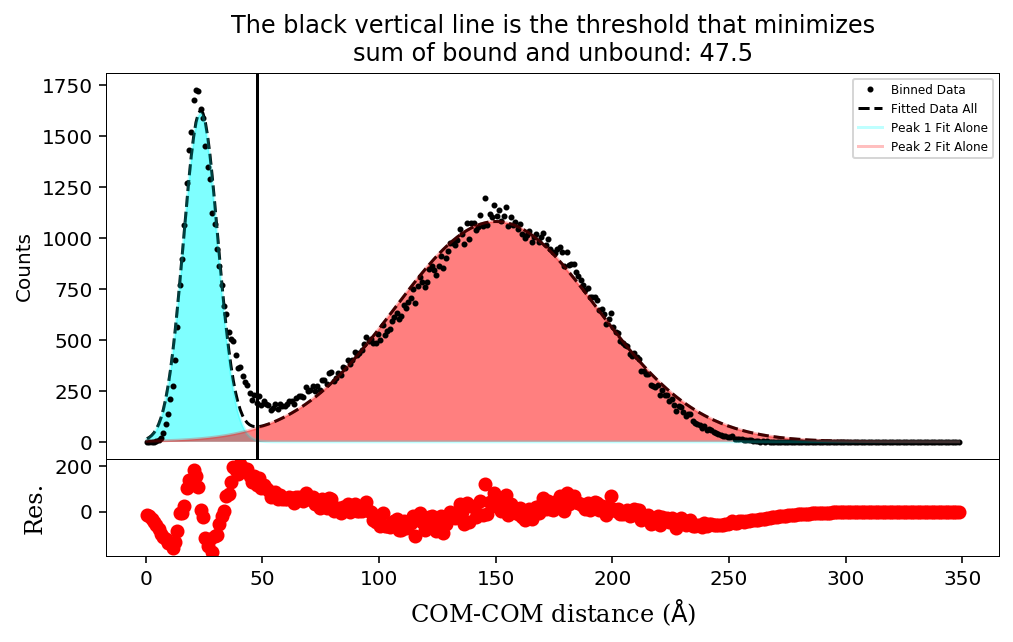

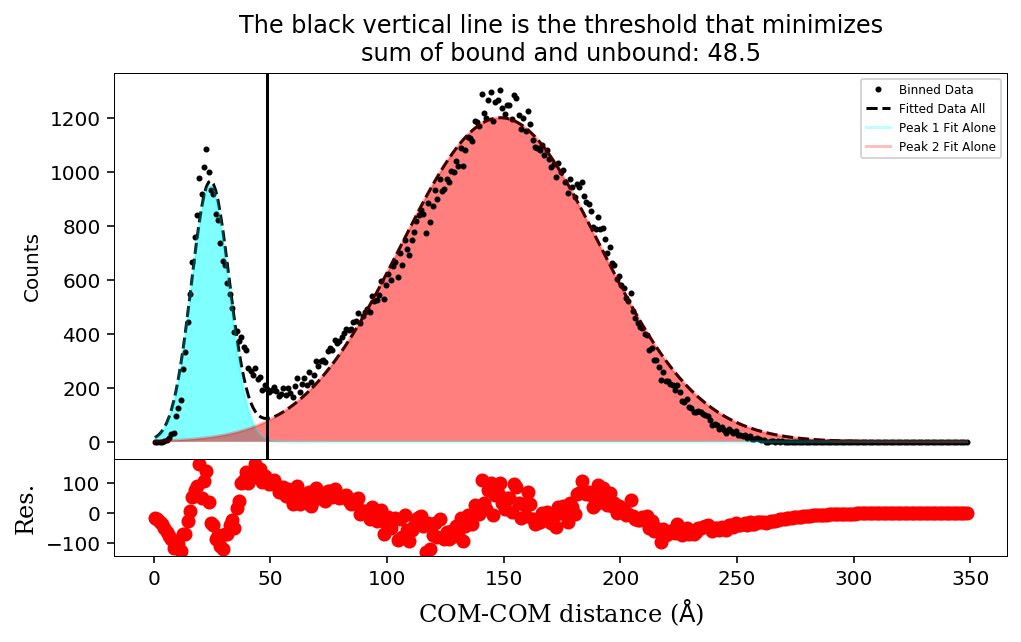

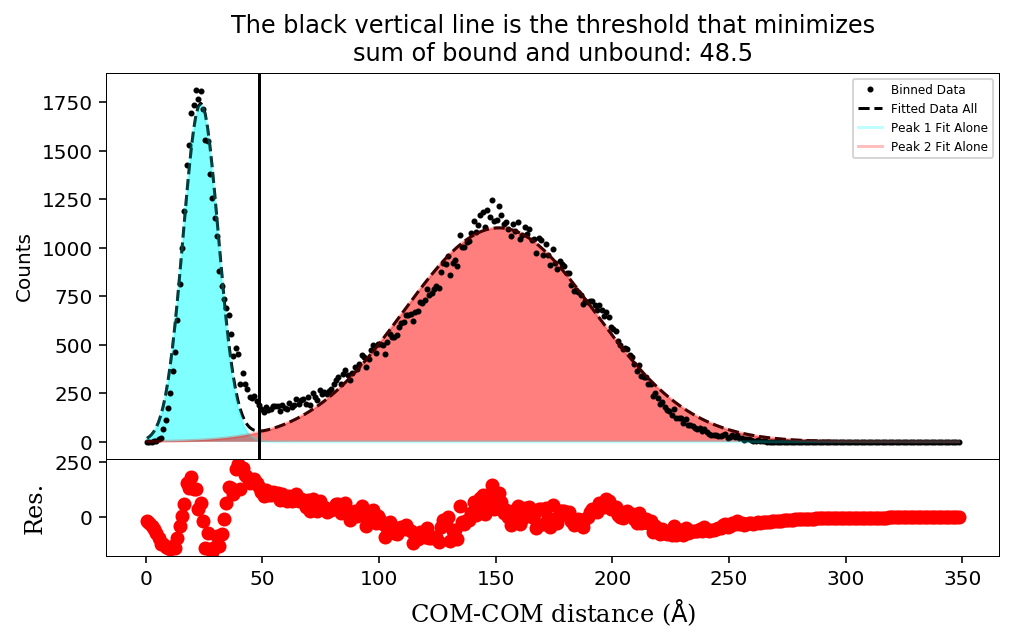

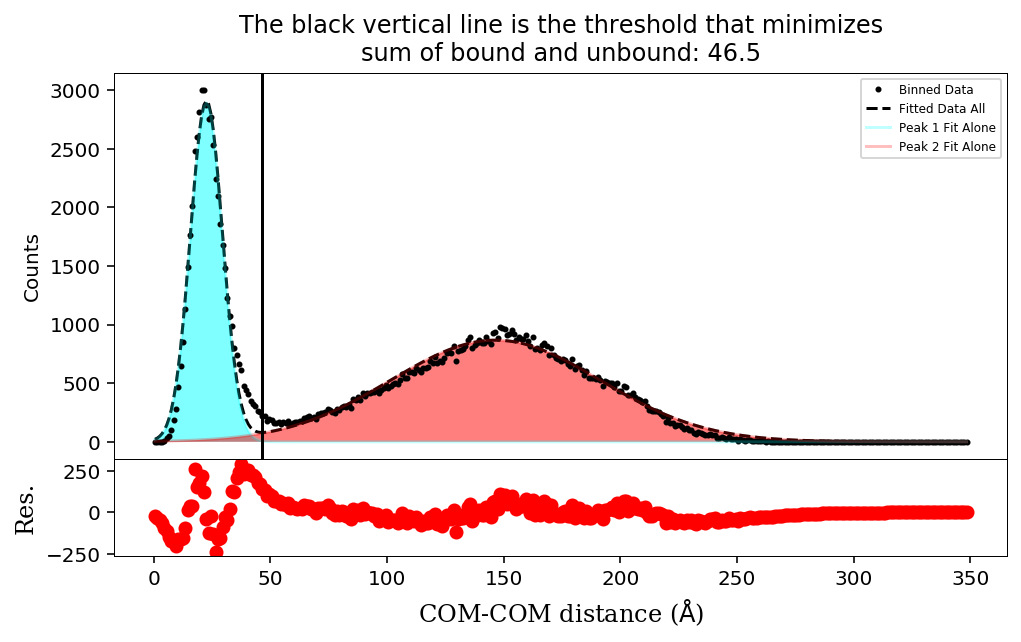

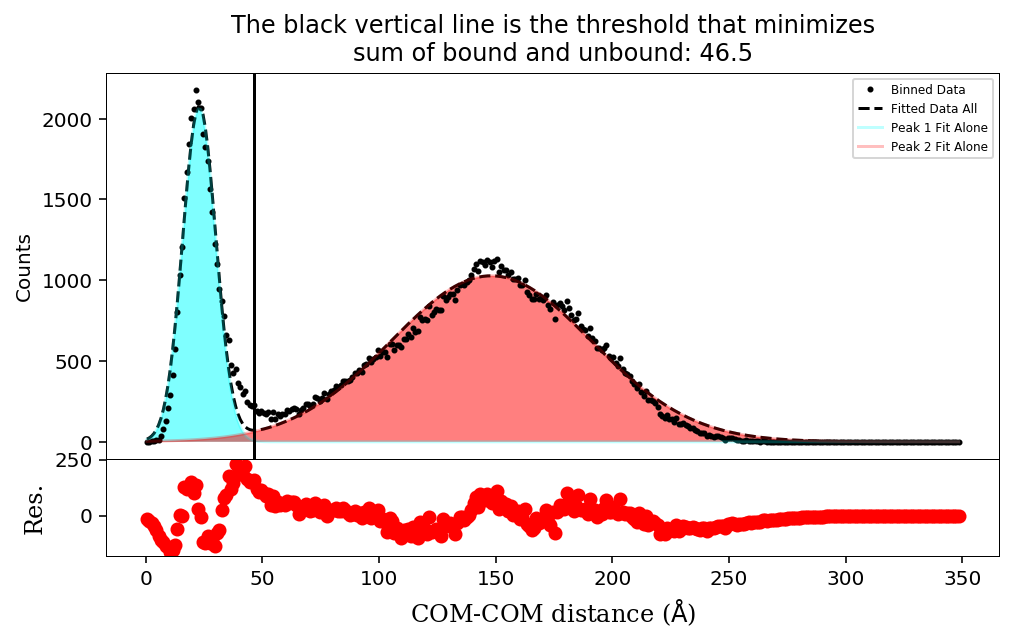

In [19]:
## This is for calculating replicates of a single type of simulation. IE 5 replicates of 1. protein and 1. RNA
## This is the main analysis cell for this entire workbook!
##

# Defines the folder where data is held
prefix = './Analysis/COMs/RBD'

# this is a single conversion factor that converts simulation Kd and Ka to experimental values
sim2exp_factor=1

# defines the number of replicates run
Replicates = [1, 2, 3, 4, 5]


# Define the Folder that your simulations are under. I make my folder names the name of the protein 
# system I am simulating. RBD_# here signifies which alphafold generated RBD structure was used

Sequences = ['SCO2_RBD_1',
'SCO2_RBD_2',
'SCO2_RBD_3',
'SCO2_RBD_4',
'SCO2_RBD_5']


# box size (in nm)
L = 30

# rdf bin width
bin_width = 0.2

# this defines the number of contigous frames below the bound cutoff we need to say a
# chain is in the bound state. I played around a bit and 10 seemed quite reasonable but
# I have't explored this all that systematically... 
bound_length = 5


# Here we want to make it easy to plot individual simulations and there replicates fast so we store each 
# simulation type as its own list of values corresponding to the desired calculation

all_Kd_naive = []
all_Ka_naive = []

all_Kd_B22 = []
all_Ka_B22 = []
all_B22s = []

all_Kd_naive_std = []
all_Ka_naive_std = []


all_Kd_B22_std = []
all_B22s_std = []
all_Ka_B22_std = []

all_fraction_bound = []
all_fraction_bound_std = []


len2COM_distance = {}
len2COM_rdfs = {}
len2COM_bound_trace = {}
len2COM_unbound_trace = {}


# main loop - note this analysis for EVERYTHING actually only takes ~5-10 seconds (!!)
for seq in Sequences:
    
    #Values to save 
    Kd_naive_ = []
    Kd_B22_ = []
    B22s_ = []
    fraction_bound_ = []
    Ka_naive_ = []
    Ka_B22_ = []
    all_Ka_naive = []
    print(seq)
    all_fraction_bound = []
    All_distance = []
    flat_list = []
    
    for rep in Replicates:
    
        # read in the COM trajectory that was previously built using the tool: lammpstools_build_comtraj
        

        CM_ss = SSTrajectory(prefix+f'/{seq}/{rep}/comtraj.xtc',
                             prefix+f'/{seq}/{rep}/comtraj.pdb', 
                             extra_valid_residue_names=['CM'])

        # distances between COM in Angstoms
        COM_distance = CM_ss.get_interchain_distance(0,1,0,0)

        # get all the COM distances for the RNA of this length and save them in case
        # we want to plot later
        len2COM_distance[rep] = COM_distance
        #print(len2COM_distance[rep])
        
    for i in Replicates:
        flat_list.append(len2COM_distance[i])
    
    All_distance = [item for sublist in flat_list for item in sublist]
    print(len(All_distance))
        
    # ######################################################
    #Creating histogram for fitting distributions

    #Make Bins for the COM distances, the range can be changed and binning changed to fit your distibution better
    np.histogram(All_distance, bins = [i for i in range(0,350,1)])

    hist, bins = np.histogram(All_distance, bins = [i for i in range(0,350,1)])
    #plt.plot(hist, color='r',linewidth=0.8)

    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    bins_average = moving_average(bins, 2)


    #Define Gaussians
    def _1gaussian(x, amp1,cen1,sigma1):
        return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((bins_average-cen1)/sigma1)**2)))

    def _2gaussian(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
        return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((bins_average-cen1)/sigma1)**2))) +\
    amp2*(1/(sigma2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((bins_average-cen2)/sigma2)**2)))


    #Initial Parameter guesses, if you get an exit due to can't divide by zero, it is worth checking your simulations for actual binding events and then picking better starting params
    amp1 = 5000
    sigma1 = 5
    cen1 = 20

    amp2 = 2500
    sigma2 = 10
    cen2 = 160

    #print(len(hist))

    #Fit
    popt_2gauss, pcov_2gauss = scipy.optimize.curve_fit(_2gaussian, bins_average, hist, p0=[amp1, cen1, sigma1, amp2, cen2, sigma2])

    perr_2gauss = np.sqrt(np.diag(pcov_2gauss))

    pars_1 = popt_2gauss[0:3]
    
    pars_2 = popt_2gauss[3:6]
    
    gauss_peak_1 = _1gaussian(bins_average, *pars_1)
    gauss_peak_2 = _1gaussian(bins_average, *pars_2)

    #get residuals of fit
    residual_2gauss = hist - (_2gaussian(bins_average, *popt_2gauss))

    #Plot global and individual fits and calculate the threshold value to use for binding, we remove this but it is a good sanity check for initial checking
    index_peak_1 = np.argmax(gauss_peak_1)
    
    index_peak_2 = np.argmax(gauss_peak_2)

    peaks = [index_peak_1,index_peak_2]
   
    sorted_peaks = sorted(peaks)

    summed_list = gauss_peak_1[sorted_peaks[0]:sorted_peaks[1]]+gauss_peak_2[sorted_peaks[0]:sorted_peaks[1]]

    minimum_index = summed_list.argmin()

    threshold = bins_average[sorted_peaks[0]:sorted_peaks[1]][minimum_index]
    print('1:', threshold)

    #print('Threshold minimizing the sum of false positives and false negatives: {0}'.format(threshold))

    """ax1.plot(bins_average, hist, "ko", markersize=2)
    ax1.plot(bins_average, _2gaussian(bins_average, *popt_2gauss), 'k--')#,\
             #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

    # peak 1
    ax1.plot(bins_average, gauss_peak_1, "cyan", alpha = 0.25)
    ax1.fill_between(bins_average, gauss_peak_1.min(), gauss_peak_1, facecolor="cyan", alpha=0.5)

    # peak 2
    ax1.plot(bins_average, gauss_peak_2, "red", alpha = 0.25)
    ax1.fill_between(bins_average, gauss_peak_2.min(), gauss_peak_2, facecolor="red", alpha=0.5)  

    ax1.axvline(threshol1,2,3,4,5,6,7,8,9,10,11,12,13,14,15d,color='black')
    ax1.set_title('The black vertical line is the threshold that minimizes\nsum of bound and unbound: {0}'.format(threshold))
    ax1.set_xlabel(r'COM-COM distance ($\rm\AA$)')
    ax1.set_ylabel('Counts')
    ax1.legend(['Binned Data','Fitted Data All','Peak 1 Fit Alone', 'Peak 2 Fit Alone'],loc='upper right')

    #fig.savefig('far_vs_near.png',bbox_inches='tight')

    # residual
    ax2.plot(bins_average, residual_2gauss, "ro")

    ax2.set_xlabel(r'COM-COM distance ($\rm\AA$)',family="serif",  fontsize=12)
    ax2.set_ylabel("Res.",family="serif",  fontsize=12)"""
    #fig.savefig('falses.png',bbox_inches='tight')

    # calculate the fraction bound
    tmp = build_traces(COM_distance, cutoff=threshold, bound_length=bound_length)

    fraction_bound = tmp[0]

    len2COM_bound_trace[rep] = tmp[1]

    len2COM_unbound_trace[rep] = tmp[2]

    # construc the radial distribution functionss using both the simple (niave) and Ganguly corrected version (Not used in this paper)
    (r, real_rdf, simple_rdf) = build_rdfs(CM_ss.traj, L, bin_width=bin_width)

    len2COM_rdfs[rep] = [r,real_rdf, simple_rdf]

    # calculate the second virial coefficient based on corrected RDF and the molecular weights of the two 
    # molecular weight of RNA (also in g/mol) 
    MW_RNA = 303.6#*rep # https://www.aatbio.com/tools/calculate-RNA-molecular-weight-mw
    b22 = calcB22(r, real_rdf, MW_N, MW_RNA)

    # calculate KD with B22 correction
    kD_B22 = kd_from_b22(b22, fraction_bound, L, MW_N, MW_RNA)

    # calculat KD naievly
    kD_niave = naive_Kd(fraction_bound, L)

    # save these data for plotting
    Kd_naive_.append(kD_niave)
    Kd_B22_.append(kD_B22)
    B22s_.append(b22)
    fraction_bound_.append(fraction_bound)

    Ka_naive_.append(1/kD_niave)
    Ka_B22_.append(1/kD_B22)

    # save these data for plotting already converted, used for when there is a conversion factor. For this paper we do not convert and instead use a normalization factor
    all_Kd_naive.append(np.mean(sim2exp_factor*np.array(Kd_naive_)*M2nM))
    all_Kd_B22.append(np.mean(sim2exp_factor*np.array(Kd_B22_)*M2nM))
    all_B22s.append(np.mean(sim2exp_factor*np.array(B22s_)*M2nM))
    all_fraction_bound.append(np.mean(sim2exp_factor*np.array(fraction_bound_)*M2nM))
    all_Ka_naive.append(np.mean(1/(sim2exp_factor*np.array(Kd_naive_)*M2nM)))
    all_Ka_B22.append(np.mean(1/(sim2exp_factor*np.array(Kd_B22_)*M2nM)))


    all_Kd_naive_std.append(np.std(sim2exp_factor*np.array(Kd_naive_)*M2nM))
    all_Kd_B22_std.append(np.std(sim2exp_factor*np.array(Kd_B22_)*M2nM))
    all_B22s_std.append(np.std(sim2exp_factor*np.array(B22s_)*M2nM))
    all_fraction_bound_std.append(np.std(sim2exp_factor*np.array(fraction_bound_)*M2nM))
    all_Ka_naive_std.append(np.std(1/(sim2exp_factor*np.array(Kd_naive_)*M2nM)))
    all_Ka_B22_std.append(np.std(1/(sim2exp_factor*np.array(Kd_B22_)*M2nM)))
        
    

    all_Ka_naive.insert(0, f'{seq}_Ka')
    all_fraction_bound.insert(0, f'{seq}_FB')
    
    print(all_Ka_naive)
    
    #Save Generated Data    
    """with open(f'./Analysis/Distances/{seq}_Distances.csv', 'w') as f:
      
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerows(map(lambda x: [x], All_distance))
        f.close()
     
    thresh = [threshold]
    with open(f'./Analysis/Cutoff/{seq}_Cutoff.csv', 'w') as f:
      
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerows([thresh])
        f.close()"""
    
    #Plot
    fig = plt.figure(figsize=(8,8))
    gs = gridspec.GridSpec(3,1, height_ratios=[1,0.25, 1])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    gs.update(hspace=0)
    
    ax1.plot(bins_average, hist, "ko", markersize=2)
    ax1.plot(bins_average, _2gaussian(bins_average, *popt_2gauss), 'k--')

    # peak 1
    ax1.plot(bins_average, gauss_peak_1, "cyan", alpha = 0.25)
    ax1.fill_between(bins_average, gauss_peak_1.min(), gauss_peak_1, facecolor="cyan", alpha=0.5)

    # peak 2
    ax1.plot(bins_average, gauss_peak_2, "red", alpha = 0.25)
    ax1.fill_between(bins_average, gauss_peak_2.min(), gauss_peak_2, facecolor="red", alpha=0.5)  

    ax1.axvline(threshold,color='black')
    ax1.set_title('The black vertical line is the threshold that minimizes\nsum of bound and unbound: {0}'.format(threshold))
    ax1.set_xlabel(r'COM-COM distance ($\rm\AA$)')
    ax1.set_ylabel('Counts')
    ax1.legend(['Binned Data','Fitted Data All','Peak 1 Fit Alone', 'Peak 2 Fit Alone'],loc='upper right')

    # residual
    ax2.plot(bins_average, residual_2gauss, "ro")

    ax2.set_xlabel(r'COM-COM distance ($\rm\AA$)',family="serif",  fontsize=12)
    ax2.set_ylabel("Res.",family="serif",  fontsize=12)

    plt.savefig(f'./Analysis/Plots/{seq}_Cutoff.png',dpi = 400, transparent = True)
    plt.savefig(f'./Analysis/Plots/{seq}_CUtoff.pdf',dpi = 400, transparent = True)


As an example We show how to use the cutoffs to assess bound and unbound fractions from individual simulations

In [22]:
#Define the sequences used
RBD = ['SCO2_RBD_1', 'SCO2_RBD_2', 'SCO2_RBD_3', 'SCO2_RBD_4', 'SCO2_RBD_5']

In [24]:
#Define threshold cutoffs for SCO2 RBD sims

len2cutoff = {}


def read_csv(filename):
    with open(filename, newline='') as f_input:
        A = ([row for row in csv.reader(f_input)])
        return([float(item) for sublist in A for item in sublist])
    
    
for l in RBD:
    A = read_csv(f'Analysis/Cutoff/{l}_Cutoff.csv')
    len2cutoff[l] = A[0]
    print(f'len2cutoff[{l}]:', len2cutoff[l])
    


len2cutoff[SCO2_RBD_1]: 47.5
len2cutoff[SCO2_RBD_2]: 48.5
len2cutoff[SCO2_RBD_3]: 48.5
len2cutoff[SCO2_RBD_4]: 46.5
len2cutoff[SCO2_RBD_5]: 46.5


In [8]:
## This is for calculating replicates of a single type of simulation. IE 5 replicates of 1. protein and 1. RNA
## This is the main analysis cell for this entire workbook!
##

# Defines the folder where data is held
prefix = './Analysis/COMs/RBD'

# this is a single conversion factor that converts simulation Kd and Ka to experimental values
sim2exp_factor=1

# defines the number of replicates run
Replicates = [1, 2, 3, 4, 5]


# Define the Folder that your simulations are under. I make my folder names the name of the protein 
# system I am simulating. RBD_# here signifies which alphafold generated RBD structure was used

Sequences = ['SCO2_RBD_1',
'SCO2_RBD_2',
'SCO2_RBD_3',
'SCO2_RBD_4',
'SCO2_RBD_5']


# box size (in nm)
L = 30

# rdf bin width
bin_width = 0.2

# this defines the number of contigous frames below the bound cutoff we need to say a
# chain is in the bound state. I played around a bit and 10 seemed quite reasonable but
# I have't explored this all that systematically... 
bound_length = 5


# Here we want to make it easy to plot individual simulations and there replicates fast so we store each 
# simulation type as its own list of values corresponding to the desired calculation

all_Kd_naive = []
all_Ka_naive = []

all_Kd_B22 = []
all_Ka_B22 = []
all_B22s = []

all_Kd_naive_std = []
all_Ka_naive_std = []


all_Kd_B22_std = []
all_B22s_std = []
all_Ka_B22_std = []

all_fraction_bound = []
all_fraction_bound_std = []


len2COM_distance = {}
len2COM_rdfs = {}
len2COM_bound_trace = {}
len2COM_unbound_trace = {}

# main loop - note this analysis for EVERYTHING actually only takes ~5-10 seconds (!!)
for seq in Sequences:
    
    Kd_naive_ = []
    Kd_B22_ = []
    B22s_ = []
    fraction_bound_ = []
    Ka_naive_ = []
    Ka_B22_ = []
    all_Ka_naive = []
    print(seq)
    all_fraction_bound = []
    
    for rep in Replicates:
    
        # read in the COM trajectory that was previously built using the script
        # build_com_traj.py (also in this directory).

        CM_ss = SSTrajectory(prefix+f'/{seq}/{rep}/comtraj.xtc',
                             prefix+f'/{seq}/{rep}/comtraj.pdb', 
                             extra_valid_residue_names=['CM'])

        # distances between COM in Angstoms
        COM_distance = CM_ss.get_interchain_distance(0,1,0,0)

        # get all the COM distances for the RNA of this length and save them in case
        # we want to plot later
        len2COM_distance[seq] = COM_distance
        
        # ######################################################
        #Creating histogram for fitting distributions
        
        #Make Bins for the COM distances 
        np.histogram(COM_distance, bins = [i for i in range(0,350,1)])

        hist, bins = np.histogram(COM_distance, bins = [i for i in range(0,350,1)])

        threshold = len2cutoff[seq]

        # calculate the fraction bound
        tmp = build_traces(COM_distance, cutoff=threshold, bound_length=bound_length)

        fraction_bound = tmp[0]

        len2COM_bound_trace[seq] = tmp[1]

        len2COM_unbound_trace[seq] = tmp[2]
        
        #Not used
        # construc the radial distribution functionss using both the simple (niave) and Ganguly corrected version
        (r, real_rdf, simple_rdf) = build_rdfs(CM_ss.traj, L, bin_width=bin_width)

        len2COM_rdfs[rep] = [r,real_rdf, simple_rdf]

        # calculate the second virial coefficient based on corrected RDF and the molecular weights of the two 
        # molecular weight of RNA (also in g/mol)
        # 
        MW_RNA = 303.6*rep # https://www.aatbio.com/tools/calculate-RNA-molecular-weight-mw
        b22 = calcB22(r, real_rdf, MW_N, MW_RNA)

        # calculate KD with B22 correction
        kD_B22 = kd_from_b22(b22, fraction_bound, L, MW_N, MW_RNA)

        # calculat KD naievly
        kD_niave = naive_Kd(fraction_bound, L)
        print(f'On RNA length: {rep}')
        
        # save these data for plotting
        Kd_naive_.append(kD_niave)
        Kd_B22_.append(kD_B22)
        B22s_.append(b22)
        fraction_bound_.append(fraction_bound)
        
        Ka_naive_.append(1/kD_niave)
        Ka_B22_.append(1/kD_B22)
    

        # save these data for plotting already converted
        all_Kd_naive.append(np.mean(sim2exp_factor*np.array(Kd_naive_)*M2nM))
        all_Kd_B22.append(np.mean(sim2exp_factor*np.array(Kd_B22_)*M2nM))
        all_B22s.append(np.mean(sim2exp_factor*np.array(B22s_)*M2nM))
        all_fraction_bound.append(np.mean(sim2exp_factor*np.array(fraction_bound_)*M2nM))
        all_Ka_naive.append(np.mean(1/(sim2exp_factor*np.array(Kd_naive_)*M2nM)))
        all_Ka_B22.append(np.mean(1/(sim2exp_factor*np.array(Kd_B22_)*M2nM)))


        all_Kd_naive_std.append(np.std(sim2exp_factor*np.array(Kd_naive_)*M2nM))
        all_Kd_B22_std.append(np.std(sim2exp_factor*np.array(Kd_B22_)*M2nM))
        all_B22s_std.append(np.std(sim2exp_factor*np.array(B22s_)*M2nM))
        all_fraction_bound_std.append(np.std(sim2exp_factor*np.array(fraction_bound_)*M2nM))
        all_Ka_naive_std.append(np.std(1/(sim2exp_factor*np.array(Kd_naive_)*M2nM)))
        all_Ka_B22_std.append(np.std(1/(sim2exp_factor*np.array(Kd_B22_)*M2nM)))
        
    

    all_Ka_naive.insert(0, f'{seq}_Ka')
    all_fraction_bound.insert(0, f'{seq}_FB')
    
    #Save
        
    """with open(f'Analysis/Data/{seq}_Ka.csv', 'w') as f:
      
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerows(map(lambda x: [x], all_Ka_naive))
        f.close()"""

SCO2_RBD_1
0.24727383904609845
On RNA length: 1
0.17430444678465876
On RNA length: 2
0.2559608722233544
On RNA length: 3
0.13377721914597276
On RNA length: 4
0.24591500492577367
On RNA length: 5
SCO2_RBD_2
0.14998131603084552
On RNA length: 1
0.10158956592622784
On RNA length: 2
0.13805754662499575
On RNA length: 3
0.1636715697931175
On RNA length: 4
0.13102558005231513
On RNA length: 5
SCO2_RBD_3
0.1567075449264531
On RNA length: 1
0.15517885654108773
On RNA length: 2
0.23289858025949325
On RNA length: 3
0.27886673234364917
On RNA length: 4
0.32592894504449427
On RNA length: 5
SCO2_RBD_4
0.45469986751367325
On RNA length: 1
0.28082331363358465
On RNA length: 2
0.38920589633856395
On RNA length: 3
0.2822298467914529
On RNA length: 4
0.358154703264599
On RNA length: 5
SCO2_RBD_5
0.2521656418792676
On RNA length: 1
0.29653157590787105
On RNA length: 2
0.34260580123632906
On RNA length: 3
0.1654380541495397
On RNA length: 4
0.23959642626626354
On RNA length: 5


Values Can then be saved and plotted as in Notebook 2E

In [3]:
## This is for calculating replicates of a single type of simulation. IE 5 replicates of 1. protein and 1. RNA
## This is the main analysis cell for this entire workbook!
##

# Defines the folder where data is held
prefix = './Analysis/COMs/RBD'

prefix = '/work/alstonj/2023/N_Protein/Fig_2/Alphafold/Run_GS'

# this is a single conversion factor that converts simulation Kd and Ka to experimental values
sim2exp_factor=1

# defines the number of replicates run
Replicates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


# Define the Folder that your simulations are under. I make my folder names the name of the protein 
# system I am simulating. RBD_# here signifies which alphafold generated RBD structure was used

Sequences = ['RBD_1',
'RBD_2',
'RBD_3',
'RBD_4',
'RBD_5']


#Define threshold cutoffs for SCO2 RBD sims

len2cutoff = {}


for l in Sequences:
    #A = read_csv(f'Analysis/Cutoff/{l}_Cutoff.csv')
    len2cutoff[l] = 47.5
    print(f'len2cutoff[{l}]:', len2cutoff[l])

# box size (in nm)
L = 30

# rdf bin width
bin_width = 0.2

# this defines the number of contigous frames below the bound cutoff we need to say a
# chain is in the bound state. I played around a bit and 10 seemed quite reasonable but
# I have't explored this all that systematically... 
bound_length = 5


# Here we want to make it easy to plot individual simulations and there replicates fast so we store each 
# simulation type as its own list of values corresponding to the desired calculation

all_Kd_naive = []
all_Ka_naive = []

all_Kd_B22 = []
all_Ka_B22 = []
all_B22s = []

all_Kd_naive_std = []
all_Ka_naive_std = []


all_Kd_B22_std = []
all_B22s_std = []
all_Ka_B22_std = []

all_fraction_bound = []
all_fraction_bound_std = []


len2COM_distance = {}
len2COM_rdfs = {}
len2COM_bound_trace = {}
len2COM_unbound_trace = {}

# main loop - note this analysis for EVERYTHING actually only takes ~5-10 seconds (!!)
for seq in Sequences:
    
    Kd_naive_ = []
    Kd_B22_ = []
    B22s_ = []
    fraction_bound_ = []
    Ka_naive_ = []
    Ka_B22_ = []
    all_Ka_naive = []
    print(seq)
    all_fraction_bound = []
    
    for rep in Replicates:
    
        # read in the COM trajectory that was previously built using the script
        # build_com_traj.py (also in this directory).

        CM_ss = SSTrajectory(prefix+f'/{seq}/{rep}/comtraj.xtc',
                             prefix+f'/{seq}/{rep}/comtraj.pdb', 
                             extra_valid_residue_names=['CM'])

        # distances between COM in Angstoms
        COM_distance = CM_ss.get_interchain_distance(0,1,0,0)

        # get all the COM distances for the RNA of this length and save them in case
        # we want to plot later
        len2COM_distance[seq] = COM_distance
        
        # ######################################################
        #Creating histogram for fitting distributions
        
        #Make Bins for the COM distances 
        np.histogram(COM_distance, bins = [i for i in range(0,350,1)])

        hist, bins = np.histogram(COM_distance, bins = [i for i in range(0,350,1)])

        threshold = len2cutoff[seq]

        # calculate the fraction bound
        tmp = build_traces(COM_distance, cutoff=threshold, bound_length=bound_length)

        fraction_bound = tmp[0]

        len2COM_bound_trace[seq] = tmp[1]

        len2COM_unbound_trace[seq] = tmp[2]
        
        #Not used
        # construc the radial distribution functionss using both the simple (niave) and Ganguly corrected version
        (r, real_rdf, simple_rdf) = build_rdfs(CM_ss.traj, L, bin_width=bin_width)

        len2COM_rdfs[rep] = [r,real_rdf, simple_rdf]

        # calculate the second virial coefficient based on corrected RDF and the molecular weights of the two 
        # molecular weight of RNA (also in g/mol)
        # 
        MW_RNA = 303.6*rep # https://www.aatbio.com/tools/calculate-RNA-molecular-weight-mw
        b22 = calcB22(r, real_rdf, MW_N, MW_RNA)

        # calculate KD with B22 correction
        kD_B22 = kd_from_b22(b22, fraction_bound, L, MW_N, MW_RNA)

        # calculat KD naievly
        kD_niave = naive_Kd(fraction_bound, L)
        print(f'On RNA length: {rep}')
        
        # save these data for plotting
        Kd_naive_.append(kD_niave)
        Kd_B22_.append(kD_B22)
        B22s_.append(b22)
        fraction_bound_.append(fraction_bound)
        
        Ka_naive_.append(1/kD_niave)
        Ka_B22_.append(1/kD_B22)
    

        # save these data for plotting already converted
        all_Kd_naive.append(np.mean(sim2exp_factor*np.array(Kd_naive_)*M2nM))
        all_Kd_B22.append(np.mean(sim2exp_factor*np.array(Kd_B22_)*M2nM))
        all_B22s.append(np.mean(sim2exp_factor*np.array(B22s_)*M2nM))
        all_fraction_bound.append(np.mean(sim2exp_factor*np.array(fraction_bound_)*M2nM))
        all_Ka_naive.append(np.mean(1/(sim2exp_factor*np.array(Kd_naive_)*M2nM)))
        all_Ka_B22.append(np.mean(1/(sim2exp_factor*np.array(Kd_B22_)*M2nM)))


        all_Kd_naive_std.append(np.std(sim2exp_factor*np.array(Kd_naive_)*M2nM))
        all_Kd_B22_std.append(np.std(sim2exp_factor*np.array(Kd_B22_)*M2nM))
        all_B22s_std.append(np.std(sim2exp_factor*np.array(B22s_)*M2nM))
        all_fraction_bound_std.append(np.std(sim2exp_factor*np.array(fraction_bound_)*M2nM))
        all_Ka_naive_std.append(np.std(1/(sim2exp_factor*np.array(Kd_naive_)*M2nM)))
        all_Ka_B22_std.append(np.std(1/(sim2exp_factor*np.array(Kd_B22_)*M2nM)))
        
    

    all_Ka_naive.insert(0, f'{seq}_Ka')
    all_fraction_bound.insert(0, f'{seq}_FB')
    
    #Save
        
    with open(f'Analysis/Data/{seq}_Ka.csv', 'w') as f:
      
        # using csv.writer method from CSV package
        write = csv.writer(f)
        write.writerows(map(lambda x: [x], all_Ka_naive))
        f.close()

len2cutoff[RBD_1]: 47.5
len2cutoff[RBD_2]: 47.5
len2cutoff[RBD_3]: 47.5
len2cutoff[RBD_4]: 47.5
len2cutoff[RBD_5]: 47.5
RBD_1
0.4163926646554354
On RNA length: 1
0.24589774884730134
On RNA length: 2
0.3009560618388934
On RNA length: 3
0.37862761052346083
On RNA length: 4
0.1813805261730404
On RNA length: 5
0.20833333333333334
On RNA length: 6
0.18205858421480878
On RNA length: 7
0.2621372389476539
On RNA length: 8
0.14605370219690805
On RNA length: 9
0.1885679414157852
On RNA length: 10
0.23972742066720912
On RNA length: 11
0.2102318958502848
On RNA length: 12
0.19677244372118252
On RNA length: 13
0.29756577163005155
On RNA length: 14
0.32780716029292106
On RNA length: 15
RBD_2
0.315093572009764
On RNA length: 1
0.23267007898037353
On RNA length: 2
0.2725793327908869
On RNA length: 3
0.1436126932465419
On RNA length: 4
0.21992812584757254
On RNA length: 5
0.32541176470588234
On RNA length: 6
0.14730810957417956
On RNA length: 7
0.11477577031287076
On RNA length: 8
0.3016341198806618
On